# Q results plotting file.

This notebook contains the code for reproducing the Q function results plots in the paper.  This is Figure B.1.  

The code is designed to read in and plot multiple experimental repeats for multiple experiments launched using the Q-function (labelled OSC) scripts in `cluster_scripts`, or, single experimental runs just by running the `RunQExperiments.py` file in `./../tests`.  

As with most sets of plotting code, this is a bit crazy in places.  It was also originally rigged to make very specifically formatted figures for the paper.  Therefore, editting any one line of code in here may cause the plot to explode, and look terrible in general.  

There is also something a bit weird in the notebook: I often find I have to run all of the cells, and then run them all again (without restarting the kernel) before the plots come out looking correct.  Thereafter it normally works great.

Feel free to rip up this code and/or nab parts of it for your own purposes.  

In [15]:
# Standard imports.
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import csv
import os
from pathlib import Path
from copy import deepcopy
from matplotlib import rc
from matplotlib.font_manager import FontProperties

# Put Matplotlib into notebook mode and change the font.
# If LaTeX x MatPlotLib is not configured on your machine, then comment this section.
%matplotlib notebook
rc('font',**{'family':'serif',
             'serif':['Palatino'], 
             'size': 8,})
rc('text', usetex=True)

# Change the dimensions of the notebook to fit window,
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Define a bunch of nice colours we will use.
from colormap import hex2rgb
muted_colours_list = ["#4878D0", "#D65F5F", "#EE854A", "#6ACC64", "#956CB4",
                      "#8C613C", "#DC7EC0", "#505050", "#D5BB67", "#82C6E2"]
muted_colours_list = np.asarray([hex2rgb(_c) for _c in muted_colours_list]) / 256
muted_colours_dict = {'blue':   muted_colours_list[0],
                      'red':    muted_colours_list[1],
                      'orange': muted_colours_list[2],
                      'green':  muted_colours_list[3],
                      'purple': muted_colours_list[4],
                      'brown':  muted_colours_list[5],
                      'pink':   muted_colours_list[6],
                      'gray':   muted_colours_list[7],
                      'yellow': muted_colours_list[8],
                      'eggsh':  muted_colours_list[9]}

# These are the textual keys for the different experiments.
exp_keys = ['RL_state', 
            'RL_partial_state', 
            'RL_observe', 
            'D_state', 
            'AD_partial_state',
            'AD_full_observe', 
            'AD_observe', 
            'A2D_partial_state',
            'A2D_observe',
            'A2D_state',
            'ete_observe',
            'RL_observe_asym']

# # These are the columns in the results.csv file.
# Algorithm steps - 0.
# Interactions -    1.
# MDP eval -        2.
# POMDP eval -      3.
# Mixed eval -      4.
# beta -            5.
# projection loss - 6.
# MDP stoch -       7.
# POMDP stoch -     8.
# Mixed stoch -     9.

# Some other colour / visual settings.
fill_alpha = 0.4
main_line_width = 1.5
edge_alpha = 0.8

# Some plotting options.
STOCHASTIC_POLICY = True
INTERACTIONS = True
SCALE = 1
APPLY_PRETRAIN_TO = ['AD', 'ete']
X_LOG_SCALE = False
Y_LOG_SCALE = True

# Set this to true and it will take only experimental repeats that are full-length.
# Otherwise, it will crop all experimental repeats to the shortest length.
PLOT_ONLY_COMPLETE = True

# Assign colours that we will use for each channel.
cols_dict = {'RL_state':           np.asarray([0.8, 0.8, 0.8, 1.0]),
             'RL_partial_state':   muted_colours_dict['orange'],
             'AD_partial_state':   muted_colours_dict['yellow'], 
             'A2D (with Q)':       muted_colours_dict['yellow'],  
             'A2D (no Q)':         muted_colours_dict['green'], }

# Paper and figure size.
paper_width = 5.5  # INCHES.
fig_size = (paper_width / 2.0, 
            paper_width / 4.0)

# Define the text labels what will appear in the legend for each channel.
labels = {'RL_state':                 'RL (MDP)', 
          'RL_partial_state':         'RL (Compact)',
          'AD_partial_state':         'AD',
          'A2D (no Q)':               'A2D (no Q)', 
          'A2D (with Q)':             'A2D (with Q)', }


# If plotting results for rolling out under deterministic policy we need to select
# a different column.
if STOCHASTIC_POLICY:
    shift = 0  # 0 for stochastic.
else:
    shift = 5  # 5 for deterministic.
    
column_to_pick = {  'RL_state':           7 - minus, # NOTE - the RL code always uses the MDP slot...
                    'RL_partial_state':   7 - minus, # NOTE - the RL code always uses the MDP slot...
                    'RL_observe':         7 - minus, # NOTE - the RL code always uses the MDP slot... 
                    'D_state':            8 - minus, 
                    'AD_partial_state':   8 - minus, 
                    'AD_full_observe':    8 - minus, 
                    'AD_observe':         8 - minus, 
                    'A2D_partial_state':  8 - minus, 
                    'A2D_observe':        8 - minus, 
                    'A2D_state':          8 - minus, 
                    'ete_observe':        8 - minus, 
                    'A2D (with Q)':       8 - minus, 
                    'A2D (no Q)':         8 - minus}


# Default args to savefig.
save_options = {'bbox_inches': 'tight', 
                'pad_inches': 0.05}

fill_alpha = 0.5
main_line_width = 1.5
edge_alpha = 0.8
max_interactions = 400000

In [16]:
leg = None
shift = 0

# Generate the reward plots.
# Generates figure B.1 middle row.
def do_reward_plot():
    
    medians = {}
    
    fig = plt.figure()
    ax = plt.gca()
    fig.set_size_inches(fig_size)
    plt.tight_layout()
    
    global leg

    for _k in reward_per_iter.keys():
        _data = reward_per_iter[_k]

        # TODO - IN HERE DECIDE IF EPISODE OR INTERACTION.
        INTERACTIONS = True
        if INTERACTIONS:
            _x = interactions[_k] / SCALE
            xlabel = 'Env. Interactions'
        else:
            _x = iters[_k]
            xlabel = 'Episodes'
            
        print(_k, len(_x))
        
        _uqu = np.quantile(_data, 0.25, axis=0)
        _lqu = np.quantile(_data, 0.75, axis=0)
        _med = np.median(_data, axis=0)

        if _k == 'semi_sym_dagger_reward':
            ax.plot(_x, _med, color=cols_dict[_k], label=_k, linewidth = main_line_width, linestyle='--')  # labels[_k]
        else:
            ax.plot(_x, _med, color=cols_dict[_k], label=_k, linewidth = main_line_width)  # labels[_k]
        
        ax.fill_between(_x, _uqu, _lqu, alpha=fill_alpha, color=cols_dict[_k], linewidth=0)
        ax.plot(_x, _lqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
        ax.plot(_x, _uqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
        
        medians[_k] = _med[-1]
        
    keys = list(asymptotic_performance.keys())
    ls = ['--', ':', '.']
    for _k in range(len(asymptotic_performance.keys())):
        _y = asymptotic_performance[keys[_k]]
        plt.plot([0, max(_x)], [_y, _y], linestyle=ls[_k], c='k', linewidth=0.5, zorder=np.inf)  # , label=keys[_k]
        

    # Only place the legend for one of the figures.
    if ENV == 'TD3':
        fontP = FontProperties()
        fontP.set_size('small')
        ax.legend(loc='lower right',
              ncol=1, fancybox=True, facecolor=[0.97, 0.97, 0.97], 
              edgecolor='k', prop=fontP, framealpha=1.0)

    
    ax.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Reward')

    plt.subplots_adjust(top = 1.0, bottom = 0.00, right = 1.0, left = 0.0, hspace = 0.01, wspace = 0.01)
    ax.margins(0.02, 0.2, tight=None)
    plt.yticks([-100, -50, 0])
    plt.ylim(-100, 20)
    plt.xlim(0, max_interactions)
    plt.xticks([0, 200000, 400000])
    
    print('fig_size', fig_size)
    fig.set_size_inches(fig_size)

    save_name = '{}_reward_{}_{}_{}.pdf'.format(tag, EXP_LABEL, STOCHASTIC_POLICY, exp_main[0].replace('/', '_'))
    save_args = {'bbox_inches': 'tight', 
                 'pad_inches': 0.05}
    
    print("Main save target: ", exp_root + save_name)

    plt.savefig(str(Path.home()) + '/Downloads/' + save_name, **save_args)
    plt.savefig(exp_root + save_name, **save_args)

    return leg
    



In [17]:
# Generate the divergence plots.
# Generates figure B.1 bottom row.
def do_divergence_plot():
    
    fig = plt.figure()
    ax = plt.gca()
    fig.set_size_inches(fig_size)
    fig.tight_layout()
    
    for _k in divergences.keys():
    
        if np.all(divergences[_k] == 0.0):
            print('Skipping: ', _k)
            return None

        if _k == 'ete_observe':
            print('Skipping:   E.T.E.')
            return None

        try:
            if INTERACTIONS:
                _x = interactions[_k] / SCALE
                xlabel = 'Env. Interactions'
            else:
                _x = iters[_k]
                xlabel = 'Episodes'
            plt.xlabel(xlabel)

            _div = divergences[_k].T
            _med = np.median(_div, axis=1)
            _lqu = np.quantile(_div, 0.25, axis=1)
            _uqu = np.quantile(_div, 0.75, axis=1)
            plt.plot(_x, _lqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha, zorder=-np.inf)
            plt.plot(_x, _uqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha, zorder=-np.inf)
            plt.plot(_x, _med, color=cols_dict[_k], label=_k, linewidth = main_line_width, zorder=np.inf)  # labels[_k]
            plt.fill_between(_x, _uqu, _lqu, alpha=fill_alpha, color=cols_dict[_k], linewidth=0)
        except Exception as err:
            print(err)
        
        
    plt.ylabel('$\\mathbb{KL}$ Div., $F(\psi)$')
    plt.grid(True)

    plt.yscale('log')

    plt.ylim([0.00001, 1])
    plt.yticks([1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
    plt.xlim(0, max_interactions)
    plt.xticks([0, 200000, 400000])

    plt.subplots_adjust(top = 1.0, bottom = 0.00, right = 1.0, left = 0.0, hspace = 0.01, wspace = 0.01)
    ax.margins(0.02, 0.2, tight=None)

    save_name = '{}_divergence_{}_{}_{}.pdf'.format(tag, EXP_LABEL, STOCHASTIC_POLICY, exp_main[0].replace('/', '_'))
    save_args = {'bbox_inches': 'tight', 
                 'pad_inches': 0.05}
    plt.savefig(str(Path.home()) + '/Downloads/' + save_name, **save_args)
    plt.savefig(exp_root + save_name, **save_args)







<IPython.core.display.Javascript object>


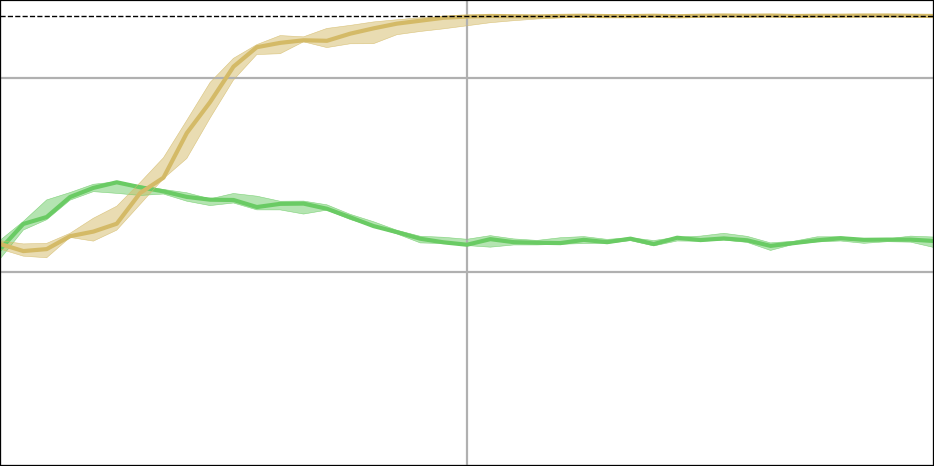

A2D (no Q) 51
A2D (with Q) 51
fig_size (2.75, 1.375)
Main save target:  ././../tests/results/AdaptAsymDagger/cr_logs/osc_cr_6/v1/cr_osc_6_q1_2021_06_07__23_18_14/OSC_TD1_lam05_reward_TigerDoor_True_v1_cr_osc_6_q0_2021_06_07__23_18_14_.pdf


<IPython.core.display.Javascript object>


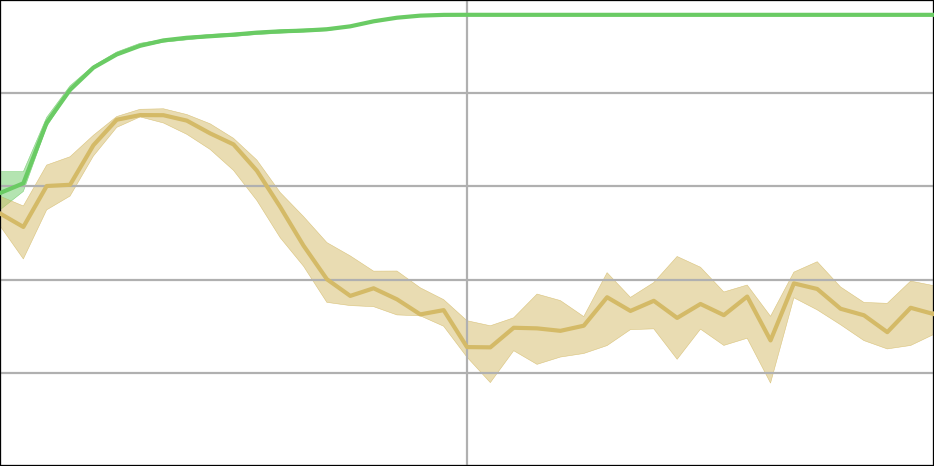

<IPython.core.display.Javascript object>


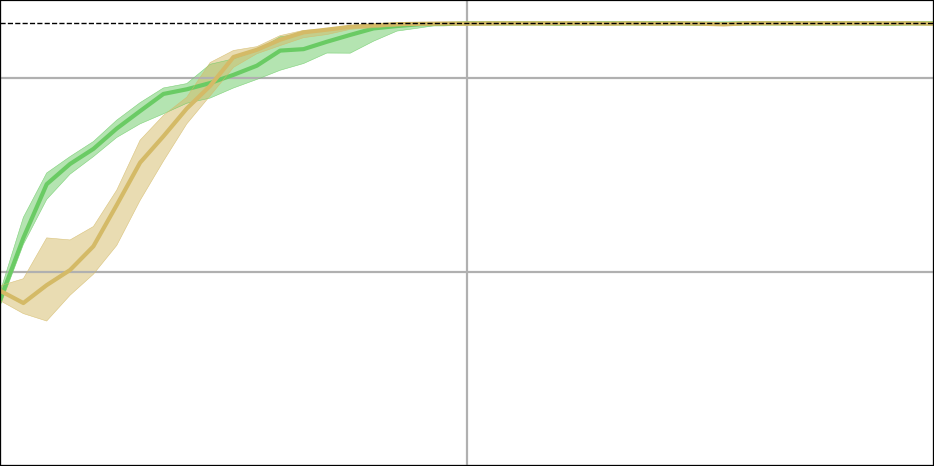

A2D (no Q) 51
A2D (with Q) 51
fig_size (2.75, 1.375)
Main save target:  ././../tests/results/AdaptAsymDagger/cr_logs/osc_cr_6/v2/cr_osc_6_q1_2021_06_07__18_05_38/OSC_TD2_lam05_reward_TigerDoor_True_v2_cr_osc_6_q0_2021_06_07__18_05_38_.pdf


<IPython.core.display.Javascript object>


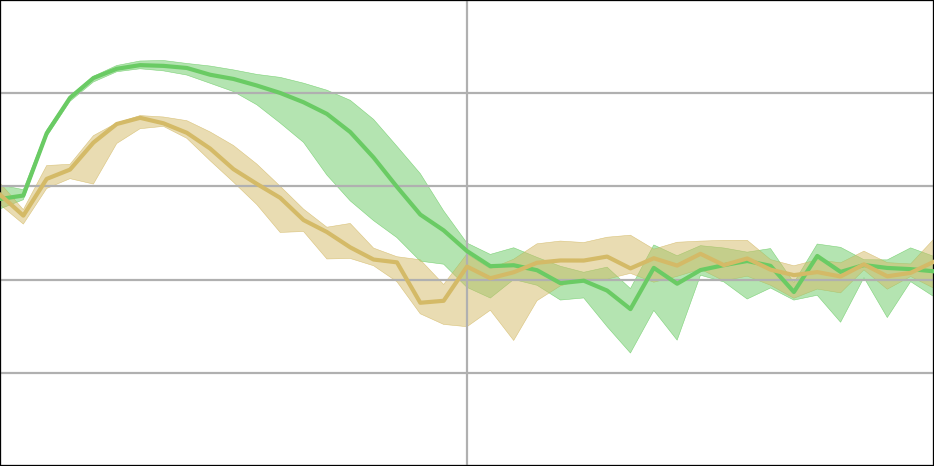

<IPython.core.display.Javascript object>


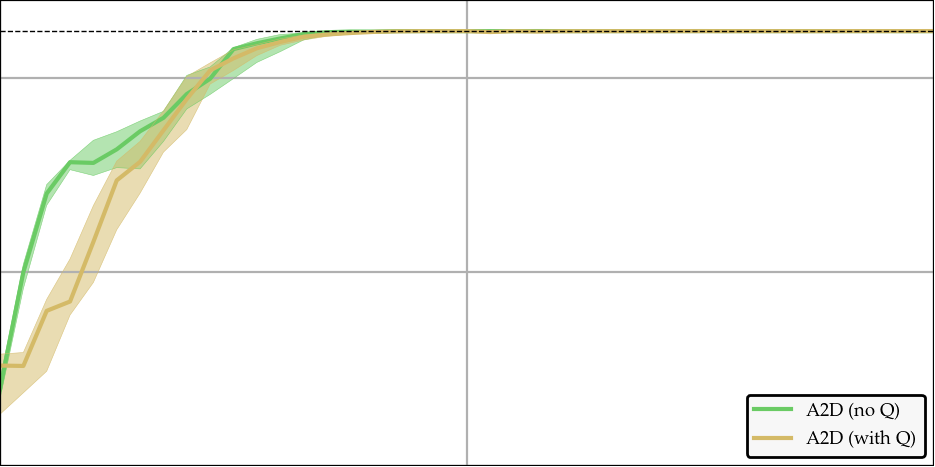

A2D (no Q) 51
A2D (with Q) 51
fig_size (2.75, 1.375)
Main save target:  ././../tests/results/AdaptAsymDagger/cr_logs/osc_cr_6/v3/cr_osc_6_q1_2021_06_07__18_05_38/OSC_TD3_lam05_reward_TigerDoor_True_v3_cr_osc_6_q0_2021_06_07__18_05_38_.pdf


<IPython.core.display.Javascript object>


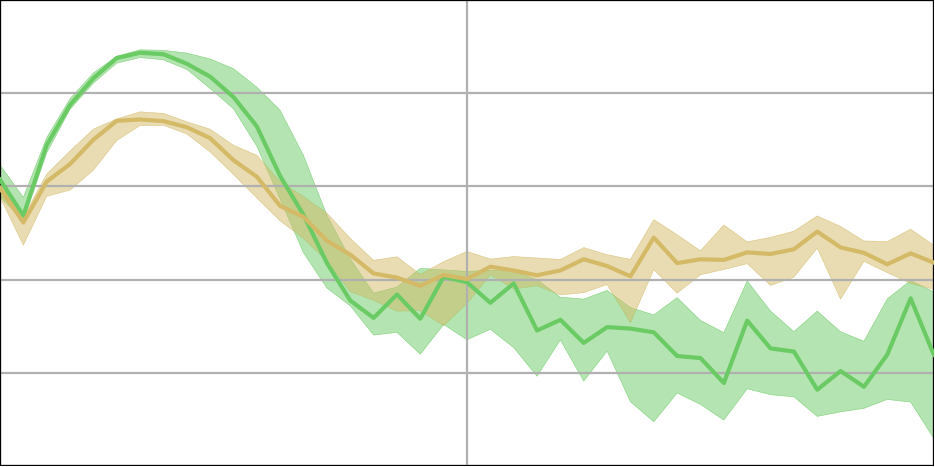

In [18]:
_exp_root = './../tests/results/AdaptAsymDagger/cr_logs/osc_cr_6/'
EXP_LABEL = 'TigerDoor'
ENVS = ['TD1', 'TD2', 'TD3']

for ENV in ENVS:

    if ENV == 'TD1':
        exp_main = ['v1/cr_osc_6_q0_2021_06_07__23_18_14/',
                    'v1/cr_osc_6_q1_2021_06_07__23_18_14/',]
        tag = 'OSC_TD1_lam05'
        asymptotic_performance = {#'MDP':   18.0,
                                  'POMDP': 16.0}

    elif ENV == 'TD2':
        exp_main = ['v2/cr_osc_6_q0_2021_06_07__18_05_38/',
                    'v2/cr_osc_6_q1_2021_06_07__18_05_38/',]
        tag = 'OSC_TD2_lam05'
        asymptotic_performance = {#'MDP':   16.0,
                                  'POMDP': 14.0}

    elif ENV == 'TD3':
        exp_main = ['v3/cr_osc_6_q0_2021_06_07__18_05_38/',
                    'v3/cr_osc_6_q1_2021_06_07__18_05_38/',]
        tag = 'OSC_TD3_lam05'
        asymptotic_performance = {#'MDP':   14.0,
                                  'POMDP': 12.0}

    else:
        raise NotImplementedError


    exp_datas = {}
    results = {}
    data = {}
    reward_per_iter = {}
    iters = {}
    interactions = {}
    divergences = {}
    EXPERT_REWARD = {}

    for _E in exp_main:
        exp_root = './' + _exp_root + _E

        files = os.listdir(exp_root)
        seeds = []
        for _r in files:
            if 'report' in _r:
                seeds.append(_r.replace('report_', '').replace('.txt', ''))

        # Random.
        experiments = ['A2D_partial_state']

        # Define asymptotic performances.
        reward_sub = 0.0  # 6.1
        reward_mul = 1.0  # -1.0


        APPLY_PRETRAIN_TO = ['AD', 'ete']

        for _k in asymptotic_performance.keys():
            asymptotic_performance[_k] -= reward_sub
            asymptotic_performance[_k] *= reward_mul


        for _e in experiments:

            try:
                _f = exp_root + _e

                data_raw = []
                lengths = []

                for _s in seeds:
                    try:
                        file = '{}/{}/results.csv'.format(_f, _s)

                        with open(file, newline='') as csvfile:
                            spamreader = csv.reader(csvfile, delimiter=',')
                            next(spamreader, None)  # Skip the header.
                            _data_raw = []
                            for row in spamreader:
                                _data_raw.append(row)

                        data_raw.append(_data_raw)
                        lengths.append(len(_data_raw))
                    except Exception as err:
                        print(err)
                        pass

                data_raw = [_d for _d in data_raw if (len(_d) == np.max(lengths))]

                if 'A2D' in _e:
                    if 'q0' in exp_root:
                        _k_in = 'A2D (no Q)'
                        q=False; v=False
                    elif 'q1' in exp_root:
                        _k_in = 'A2D (with Q)'
                        q=True; v=False
                    else:
                        raise NotImplemented
                else:
                    _k_in = _k

                data_raw = np.asarray(data_raw).astype(np.float)
                data[_k_in] = data_raw

            except Exception as err:
                print('Loading {} failed: '.format(_e), err)

        results = {}


        for _k in data.keys():

            try:
                # Check it can load all entries.
                data[_k][:, :, column_to_pick[_k]]
                data[_k][:, :, 0]
                data[_k][:, :, 1]
                data[_k][:, :, 6]

                _k_in = _k

                reward_per_iter[_k_in] = (data[_k][:, :, column_to_pick[_k]] - reward_sub) * reward_mul
                divergences[_k_in] = data[_k][:, :, 6]
                iters[_k_in] = np.mean(data[_k][:, :, 0], axis=0)
                interactions[_k_in] = np.mean(data[_k][:, :, 1], axis=0)

                divergences[_k_in][divergences[_k_in] == 90210.0] = np.nan
            except Exception as err:
                print(_k, 'failed', err)
                pass

    leg = do_reward_plot()
    do_divergence_plot()
